# Combinatorial Purged Cross-Validation — Visualization

Adapted from [Berend Gort's CPCV notebook](https://pub.towardsai.net/the-combinatorial-purged-cross-validation-method-363eb378a9c5) for the **ElegantRL Alpaca stock trading** pipeline.

Original plotting based on [sklearn's CV visualisation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).

Reference: *Advances in Financial Machine Learning*, Marcos Lopez de Prado, 2018.

### Imports

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('../..'))

import numpy as np
import matplotlib.pyplot as plt
import itertools as itt
from math import comb

from cpcv_pipeline.function_CPCV import (
    CombPurgedKFoldCV,
    AdaptiveCombPurgedKFoldCV,
    BaggedCombPurgedKFoldCV,
    back_test_paths_generator,
)
from cpcv_pipeline.config import (
    N_GROUPS, K_TEST_GROUPS, EMBARGO_DAYS,
    ALPACA_NPZ_PATH,
)


In [2]:
# Plot settings (matching Berend Gort's notebook)

SCALE_FACTOR = 1

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

## Load Alpaca dataset

In [3]:
data = np.load(ALPACA_NPZ_PATH, allow_pickle=True)
close_ary = data['close_ary']
tech_ary = data['tech_ary']
dates_ary = data['dates_ary']       # e.g. ['2021-01-04', ..., '2023-12-29']
tickers_ary = data['tickers_ary']   # e.g. ['AAPL', 'AMGN', ..., 'WMT']

total_samples = close_ary.shape[0]
n_stocks = close_ary.shape[1]
tech_cols = tech_ary.shape[1]

# 226 = 8 indicators × 28 stocks + VIX + turbulence
n_market_indicators = 2                          # VIX, turbulence
n_tech_per_stock = (tech_cols - n_market_indicators) // n_stocks  # 8

print(f'Dataset : {total_samples} days × {n_stocks} stocks')
print(f'Date range: {dates_ary[0]} to {dates_ary[-1]}')
print(f'Tickers: {", ".join(tickers_ary[:5])} ... {", ".join(tickers_ary[-3:])} ({len(tickers_ary)} total)')
print(f'Tech cols: {tech_cols}  =  {n_tech_per_stock} indicators × {n_stocks} stocks + {n_market_indicators} market-wide (VIX, turbulence)')
print(f'Indicators per stock: MACD, Boll_UB, Boll_LB, RSI-30, CCI-30, DX-30, SMA-30, SMA-60')
print(f'Data path: {ALPACA_NPZ_PATH}')

Dataset : 753 days × 28 stocks
Date range: 2021-01-04 to 2023-12-29
Tickers: AAPL, AMGN, AXP, BA, CAT ... V, VZ, WMT (28 total)
Tech cols: 226  =  8 indicators × 28 stocks + 2 market-wide (VIX, turbulence)
Indicators per stock: MACD, Boll_UB, Boll_LB, RSI-30, CCI-30, DX-30, SMA-30, SMA-60
Data path: /mnt/ssd_backup/ElegantRL/datasets/alpaca_stock_data.numpy.npz


## Set CPCV constants

In [4]:
# CPCV parameters (from cpcv_pipeline/config.py)

N = N_GROUPS          # 5 fold groups
K = K_TEST_GROUPS     # 2 test groups per split
embargo = EMBARGO_DAYS  # 7-day embargo

n_splits = comb(N, K)            # C(5,2) = 10
n_paths = n_splits * K // N      # 10*2/5 = 4

print(f'N={N}, K={K}, embargo={embargo}d')
print(f'n_splits (simulations): {n_splits}')
print(f'n_paths (backtest paths): {n_paths}')

N=5, K=2, embargo=7d
n_splits (simulations): 10
n_paths (backtest paths): 4


## Combinatorial PurgedKFoldCV

Our `CombPurgedKFoldCV` splits the data into N contiguous fold groups, selects C(N,K) combinations of K folds as test sets, and applies **purging** + **embargo** to prevent data leakage in the training set.

Key difference from the original notebook: our implementation operates on integer sample counts (no pandas DataFrames or Timedelta required), making it simpler for array-based RL environments.

In [5]:
cv = CombPurgedKFoldCV(n_splits=N, n_test_splits=K, embargo_days=embargo)

print(f'CV object: {type(cv).__name__}')
print(f'Combinations: {cv.n_combinations}')
print(f'Paths: {cv.n_paths}')
print(f'Fold bounds: {cv.get_fold_bounds(total_samples)}')

CV object: CombPurgedKFoldCV
Combinations: 10
Paths: 4
Fold bounds: [(0, 150), (150, 300), (300, 450), (450, 600), (600, 753)]


### Inspect the splits

Each split yields `(train_indices, test_indices)` as numpy arrays. Samples not in either set are purged/embargoed.

In [6]:
from cpcv_pipeline.function_CPCV import format_segments

def _contiguous_segments(idx):
    """Split an index array into contiguous segments."""
    if len(idx) == 0:
        return []
    segments, start = [], 0
    for j in range(1, len(idx)):
        if idx[j] != idx[j-1] + 1:
            segments.append(idx[start:j])
            start = j
    segments.append(idx[start:])
    return segments

def _seg_summary(idx):
    """Show each contiguous segment with dates and length."""
    segs = _contiguous_segments(idx)
    return ' + '.join(f'{dates_ary[s[0]]}..{dates_ary[s[-1]]} ({len(s)}d)' for s in segs)

for i, (tr, tt) in enumerate(cv.split(total_samples)):
    embargo_idx = sorted(set(range(total_samples)) - set(tr) - set(tt))
    print(f'Split {i+1:2d}: train={len(tr):4d}  test={len(tt):4d}  purge/embargo={len(embargo_idx):3d}')
    print(f'    train: {_seg_summary(tr)}')
    print(f'           {format_segments(tr)}')
    print(f'    test:  {_seg_summary(tt)}')
    print(f'           {format_segments(tt)}')
    if embargo_idx:
        print(f'    emb:   {_seg_summary(np.array(embargo_idx))}')

Split  1: train= 449  test= 303  purge/embargo=  1
    train: 2021-01-04..2022-10-13 (449d)
           [0..448]
    test:  2022-10-17..2023-12-29 (303d)
           [450..752]
    emb:   2022-10-14..2022-10-14 (1d)
Split  2: train= 441  test= 303  purge/embargo=  9
    train: 2021-01-04..2022-03-10 (299d) + 2022-10-26..2023-05-19 (142d)
           [0..298] + [457..598]
    test:  2022-03-14..2022-10-14 (150d) + 2023-05-23..2023-12-29 (153d)
           [300..449] + [600..752]
    emb:   2022-03-11..2022-03-11 (1d) + 2022-10-17..2022-10-25 (7d) + 2023-05-22..2023-05-22 (1d)
Split  3: train= 445  test= 300  purge/embargo=  8
    train: 2021-01-04..2022-03-10 (299d) + 2023-06-02..2023-12-29 (146d)
           [0..298] + [607..752]
    test:  2022-03-14..2023-05-22 (300d)
           [300..599]
    emb:   2022-03-11..2022-03-11 (1d) + 2023-05-23..2023-06-01 (7d)
Split  4: train= 441  test= 303  purge/embargo=  9
    train: 2021-01-04..2021-08-05 (149d) + 2022-03-23..2023-05-19 (292d)
         

### The plotting function for the Combinatorial PurgedKFold

Made this based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [7]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap_data = plt.cm.Paired

# 3-color map: 0=train (blue), 1=test (red), 2=embargo/purged (dark grey)
cmap_cv = ListedColormap(['#3B82F6', '#EF4444', '#6B7280'])
norm_cv = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap_cv.N)

def plot_cv_indices(cv, total_samples, ax, lw=5, dates=None):
    """Create a sample plot for indices of a cross-validation object."""

    n_splits = cv.n_combinations

    # Assign each sample to a fold group (for the "class" column)
    fold_bounds = cv.get_fold_bounds(total_samples)
    group = np.zeros(total_samples, dtype=int)
    for g, (s, e) in enumerate(fold_bounds):
        group[s:e] = g

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(total_samples)):

        # Fill in indices with the training/test groups
        # 0 = train, 1 = test, 2 = embargo/purged
        indices = np.full(total_samples, 2, dtype=int)  # default = embargo
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            [ii + 0.5] * len(indices),
            range(len(indices)),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            norm=norm_cv,
        )

    # Plot the fold groups ("class" column) at the end
    ax.scatter(
        [ii + 1.5] * total_samples,
        range(total_samples),
        c=group,
        marker="_",
        lw=lw,
        cmap=cmap_data
    )

    # Plot continuous sample index ("group" column)
    ax.scatter(
        [ii + 2.5] * total_samples,
        range(total_samples),
        c=list(range(total_samples)),
        marker="_",
        lw=lw,
        cmap=cmap_data
    )

    # Formatting
    xlabelz = list(range(n_splits, 0, -1))
    xlabelz = ['S' + str(x) for x in xlabelz]
    xticklabels = xlabelz + ["class", "group"]

    ax.set(
        xticks=np.arange(n_splits + 2) + 0.45,
        xticklabels=xticklabels,
        xlabel="CV iteration",
        xlim=[n_splits + 2.2, -0.2],
        ylim=[0, total_samples],
    )

    # Date labels on y-axis
    if dates is not None and len(dates) == total_samples:
        n_ticks = 8
        tick_idx = np.linspace(0, total_samples - 1, n_ticks, dtype=int)
        ax.set_yticks(tick_idx)
        ax.set_yticklabels([dates[i] for i in tick_idx], fontsize=3.5)
        ax.set_ylabel('Date')
    else:
        ax.set_ylabel('Sample index')

    ax.set_title("{}".format(type(cv).__name__), fontsize=5)
    ax.xaxis.tick_top()

    # Legend
    from matplotlib.patches import Patch
    legend_items = [Patch(color='#3B82F6', label='Train'),
                    Patch(color='#EF4444', label='Test'),
                    Patch(color='#6B7280', label='Embargo')]
    ax.legend(handles=legend_items, loc='lower left', fontsize=4,
              framealpha=0.8, ncol=3)

    return ax

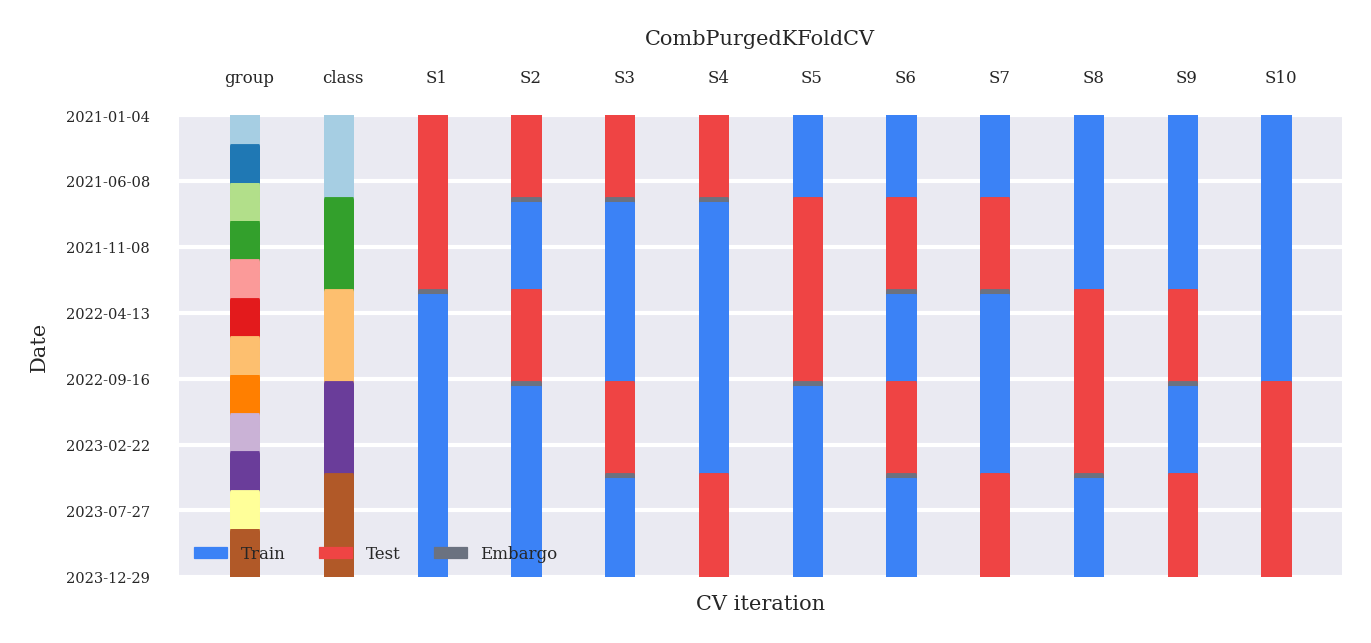

In [8]:
# Plot CPCV splits on the Alpaca dataset

fig, ax = plt.subplots()
plot_cv_indices(cv, total_samples, ax, dates=dates_ary)
plt.gca().invert_yaxis()

## Backtest paths

The generator function for the unique paths. Each backtest path stitches together test folds from different splits to cover 100% of the timeline, giving φ = C(N,K)·K/N independent OOS equity curves.

In [9]:
# Compute backtest paths on the full Alpaca dataset

is_test, paths, path_folds = back_test_paths_generator(total_samples, N, K)

print(f'is_test shape: {is_test.shape}   (samples × splits)')
print(f'paths shape:   {paths.shape}     (samples × paths)')
print(f'path_folds shape: {path_folds.shape} (groups × paths)')

is_test shape: (753, 10)   (samples × splits)
paths shape:   (753, 4)     (samples × paths)
path_folds shape: (5, 4) (groups × paths)


### Paths example

Small example (30 samples, 6 groups) to see the path assignments clearly, like the original notebook.

In [10]:
# Compute backtest paths (small example)
_, paths_small, _ = back_test_paths_generator(30, 6, 2)
paths_small + 1

array([[ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 1.,  6.,  7.,  8.,  9.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 2.,  6., 10., 11., 12.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 3.,  7., 10., 13., 14.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 4.,  8., 11., 13., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  9., 12., 14., 15.],
       [ 5.,  

In [11]:
paths_small.shape

(30, 5)

### Path fold assignments (full dataset)

`path_folds[g, p]` = which split provides the OOS prediction for group `g` in path `p`.

In [12]:
import pandas as pd

pf_df = pd.DataFrame(
    (path_folds + 1).astype(int),
    index=[f'Group {g}' for g in range(N)],
    columns=[f'Path {p+1}' for p in range(n_paths)],
)
pf_df.index.name = 'Fold Group'
pf_df

,Path 1,Path 2,Path 3,Path 4
Fold Group,,,,
Group 0,1,2,3,4
Group 1,1,5,6,7
Group 2,2,5,8,9
Group 3,3,6,8,10
Group 4,4,7,9,10


## Verify no leakage

Confirm that train and test indices never overlap in any split, and that the embargo gap exists around every test fold boundary.

In [13]:
from cpcv_pipeline.function_CPCV import verify_no_leakage

assert verify_no_leakage(cv, total_samples)
print(f'✓ All {n_splits} splits are leak-free (embargo={embargo}d)')

✓ All 10 splits are leak-free (embargo=7d)


---

# Walk-Forward Cross-Validation

Anchored walk-forward: fold *i* trains on `[0 : (i+1)·fold_size]` and tests on the next block (with embargo gap). Training set grows with each fold — no future data ever leaks.


In [14]:
from cpcv_pipeline.optimize_wf import get_wf_splits
from cpcv_pipeline.config import WF_GAP_DAYS

wf_splits = get_wf_splits(total_samples, n_folds=5, gap_days=WF_GAP_DAYS)

print(f'Walk-Forward: {len(wf_splits)} folds, gap={WF_GAP_DAYS}d\n')
for i, (tr, tt) in enumerate(wf_splits):
    gap = total_samples - len(tr) - len(tt)
    print(f'  Fold {i+1}: train={len(tr):4d}d [{dates_ary[tr[0]]}..{dates_ary[tr[-1]]}]  '
          f'test={len(tt):3d}d [{dates_ary[tt[0]]}..{dates_ary[tt[-1]]}]  '
          f'unused={gap:3d}d')

Walk-Forward: 5 folds, gap=7d

  Fold 1: train= 125d [2021-01-04..2021-07-01]  test=125d [2021-07-14..2022-01-07]  unused=503d
  Fold 2: train= 250d [2021-01-04..2021-12-29]  test=125d [2022-01-10..2022-07-11]  unused=378d
  Fold 3: train= 375d [2021-01-04..2022-06-29]  test=125d [2022-07-12..2023-01-06]  unused=253d
  Fold 4: train= 500d [2021-01-04..2022-12-27]  test=125d [2023-01-09..2023-07-10]  unused=128d
  Fold 5: train= 625d [2021-01-04..2023-06-28]  test=121d [2023-07-11..2023-12-29]  unused=  7d


In [15]:
def plot_splits_generic(splits, total_samples, ax, title='', lw=5, dates=None):
    """Plot train/test/unused for a list of (train_idx, test_idx) splits.
    If dates is provided, use date labels on the y-axis."""
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from matplotlib.patches import Patch

    cmap_cv = ListedColormap(['#3B82F6', '#EF4444', '#6B7280'])
    norm_cv = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap_cv.N)
    n = len(splits)

    for ii, (tr, tt) in enumerate(splits):
        indices = np.full(total_samples, 2, dtype=int)  # 2 = unused/embargo
        indices[tt] = 1  # test
        indices[tr] = 0  # train

        ax.scatter(
            [ii + 0.5] * total_samples,
            range(total_samples),
            c=indices, marker='_', lw=lw,
            cmap=cmap_cv, norm=norm_cv,
        )

    xlabels = [f'F{i+1}' for i in range(n)]
    ax.set(
        xticks=np.arange(n) + 0.5,
        xticklabels=xlabels,
        xlabel='Fold',
        xlim=[n + 0.2, -0.2],
        ylim=[0, total_samples],
    )

    # Date labels on y-axis
    if dates is not None and len(dates) == total_samples:
        n_ticks = 8
        tick_idx = np.linspace(0, total_samples - 1, n_ticks, dtype=int)
        ax.set_yticks(tick_idx)
        ax.set_yticklabels([dates[i] for i in tick_idx], fontsize=3.5)
        ax.set_ylabel('Date')
    else:
        ax.set_ylabel('Day index')

    ax.set_title(title, fontsize=6)
    ax.xaxis.tick_top()

    legend_items = [
        Patch(color='#3B82F6', label='Train'),
        Patch(color='#EF4444', label='Test'),
        Patch(color='#6B7280', label='Embargo/Unused'),
    ]
    ax.legend(handles=legend_items, loc='lower left',
              fontsize=4, framealpha=0.8, ncol=3)
    return ax

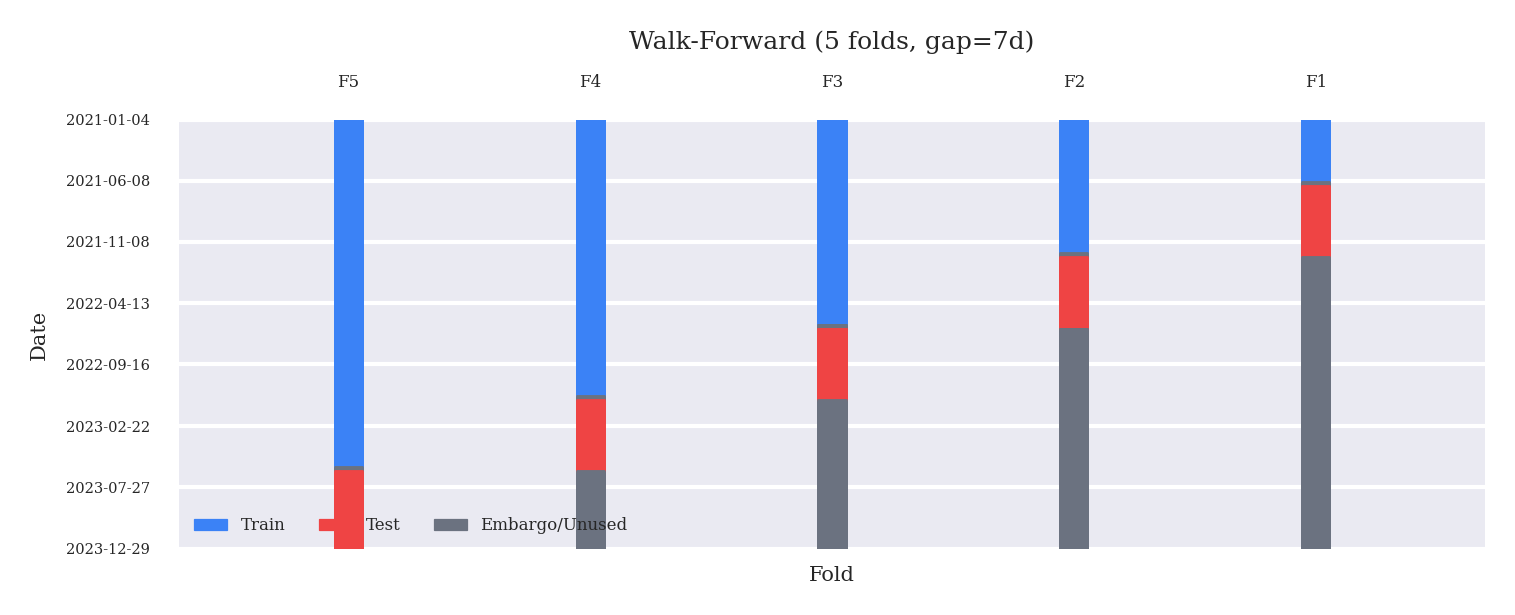

In [16]:
# Plot Walk-Forward splits
fig, ax = plt.subplots()
plot_splits_generic(wf_splits, total_samples, ax,
                    title=f'Walk-Forward (5 folds, gap={WF_GAP_DAYS}d)',
                    dates=dates_ary)
plt.gca().invert_yaxis()
plt.tight_layout()

---

# K-Fold Cross-Validation (with Purging)

Standard K-fold where each fold is a contiguous block used as test. Train set = all other folds minus 1-day purge before test and 7-day embargo after test. Unlike CPCV, each sample appears in the test set exactly once.


In [17]:
from cpcv_pipeline.optimize_kcv import get_kcv_splits

kcv_splits = get_kcv_splits(total_samples, n_folds=5, gap_days=embargo)

print(f'K-Fold CV: {len(kcv_splits)} folds, embargo={embargo}d\n')
for i, (tr, tt) in enumerate(kcv_splits):
    gap = total_samples - len(tr) - len(tt)
    print(f'  Fold {i+1}: train={len(tr):4d}d  '
          f'test={len(tt):3d}d [{dates_ary[tt[0]]}..{dates_ary[tt[-1]]}]  '
          f'purge+embargo={gap:2d}d')

K-Fold CV: 5 folds, embargo=7d

  Fold 1: train= 596d  test=150d [2021-01-04..2021-08-06]  purge+embargo= 7d
  Fold 2: train= 595d  test=150d [2021-08-09..2022-03-11]  purge+embargo= 8d
  Fold 3: train= 595d  test=150d [2022-03-14..2022-10-14]  purge+embargo= 8d
  Fold 4: train= 595d  test=150d [2022-10-17..2023-05-22]  purge+embargo= 8d
  Fold 5: train= 599d  test=153d [2023-05-23..2023-12-29]  purge+embargo= 1d


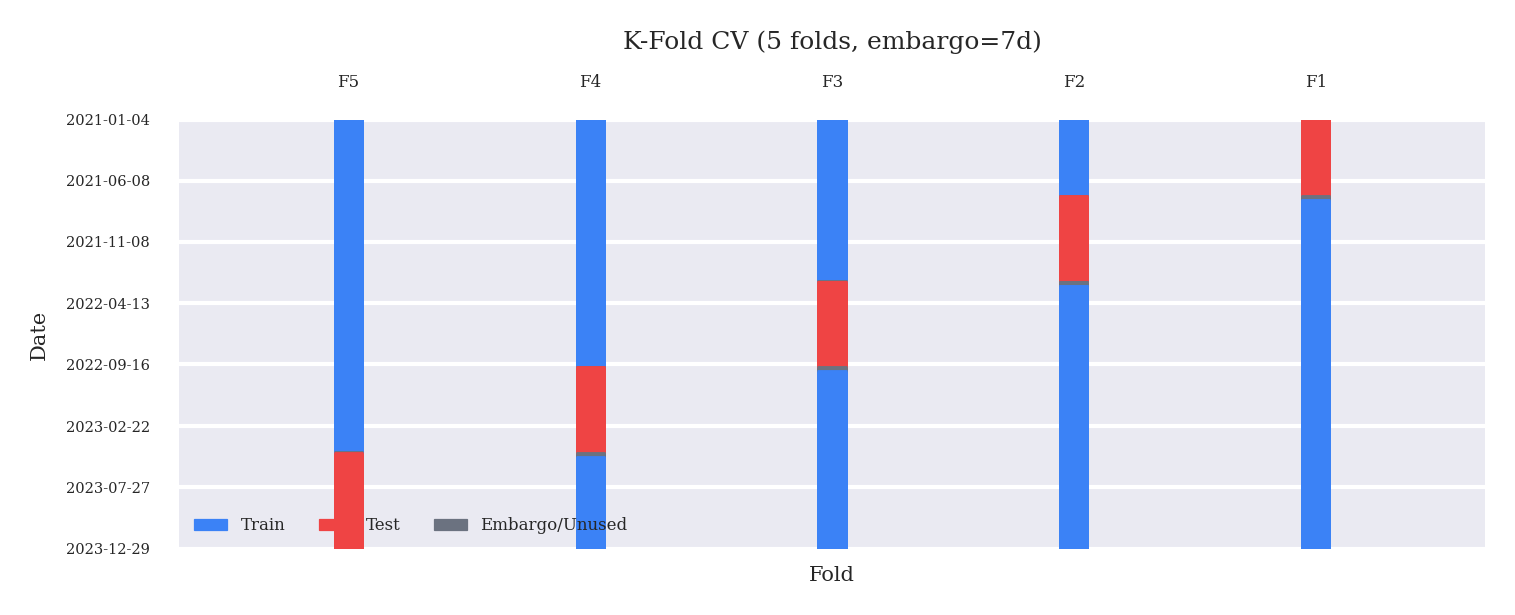

In [18]:
# Plot K-Fold CV splits
fig, ax = plt.subplots()
plot_splits_generic(kcv_splits, total_samples, ax,
                    title=f'K-Fold CV (5 folds, embargo={embargo}d)',
                    dates=dates_ary)
plt.gca().invert_yaxis()
plt.tight_layout()

---

# Adaptive CPCV (A-CPCV)

Group boundaries shift based on an external feature so that splits avoid cutting through regime transitions.

Each initial equal-width group is subdivided into `n_subsplits` fine-grained sub-intervals. At each boundary, the feature value is checked against quantile thresholds:
- Feature **below Q25** → shift boundary **right** by one sub-interval (absorb the calm regime into the next group)
- Feature **above Q75** → shift boundary **left** by one sub-interval (push the volatile regime into the next group)
- Feature **between Q25–Q75** → no shift

The net effect is that boundaries move *away* from extreme feature values, keeping similar-regime days together within the same fold group.

Best feature (empirically): **63-day rolling drawdown** — achieves lowest regime gap (AvgGap=8.9%) and 0 strict mismatches vs 3 for standard CPCV.

Reference: RiskLabAI — *Adaptive Combinatorial Purged Cross-Validation*.


In [19]:
# Compute rolling portfolio volatility as the external feature
from cpcv_pipeline.function_CPCV import compute_external_feature

vol = compute_external_feature(close_ary, feature_name='volatility', window=21)
print(f'Rolling volatility: shape={vol.shape}, '
      f'range=[{vol.min():.6f}, {vol.max():.6f}], '
      f'mean={vol.mean():.6f}')

# Create Adaptive CPCV splitter
acv = AdaptiveCombPurgedKFoldCV(
    n_splits=N, n_test_splits=K, embargo_days=embargo,
    external_feature=vol,
    n_subsplits=3,
    lower_quantile=0.25,
    upper_quantile=0.75,
)

print(f'\nAdaptive CPCV: {acv.n_combinations} splits, {acv.n_paths} paths')
print(acv.describe_splits(total_samples))

Rolling volatility: shape=(753,), range=[0.003639, 0.017266], mean=0.008742

Adaptive CPCV: 10 splits, 4 paths
Adaptive CPCV: N=5, K=2, embargo=7d, subsplits=3, quantiles=[0.25, 0.75]
Total samples: 753
Number of splits: 10
Number of paths: 4

Adaptive fold boundaries:
  Group 0: [0:151] (151 days, +1 vs equal)
  Group 1: [151:251] (100 days, -50 vs equal)
  Group 2: [251:402] (151 days, +1 vs equal)
  Group 3: [402:602] (200 days, +50 vs equal)
  Group 4: [602:753] (151 days, +1 vs equal)


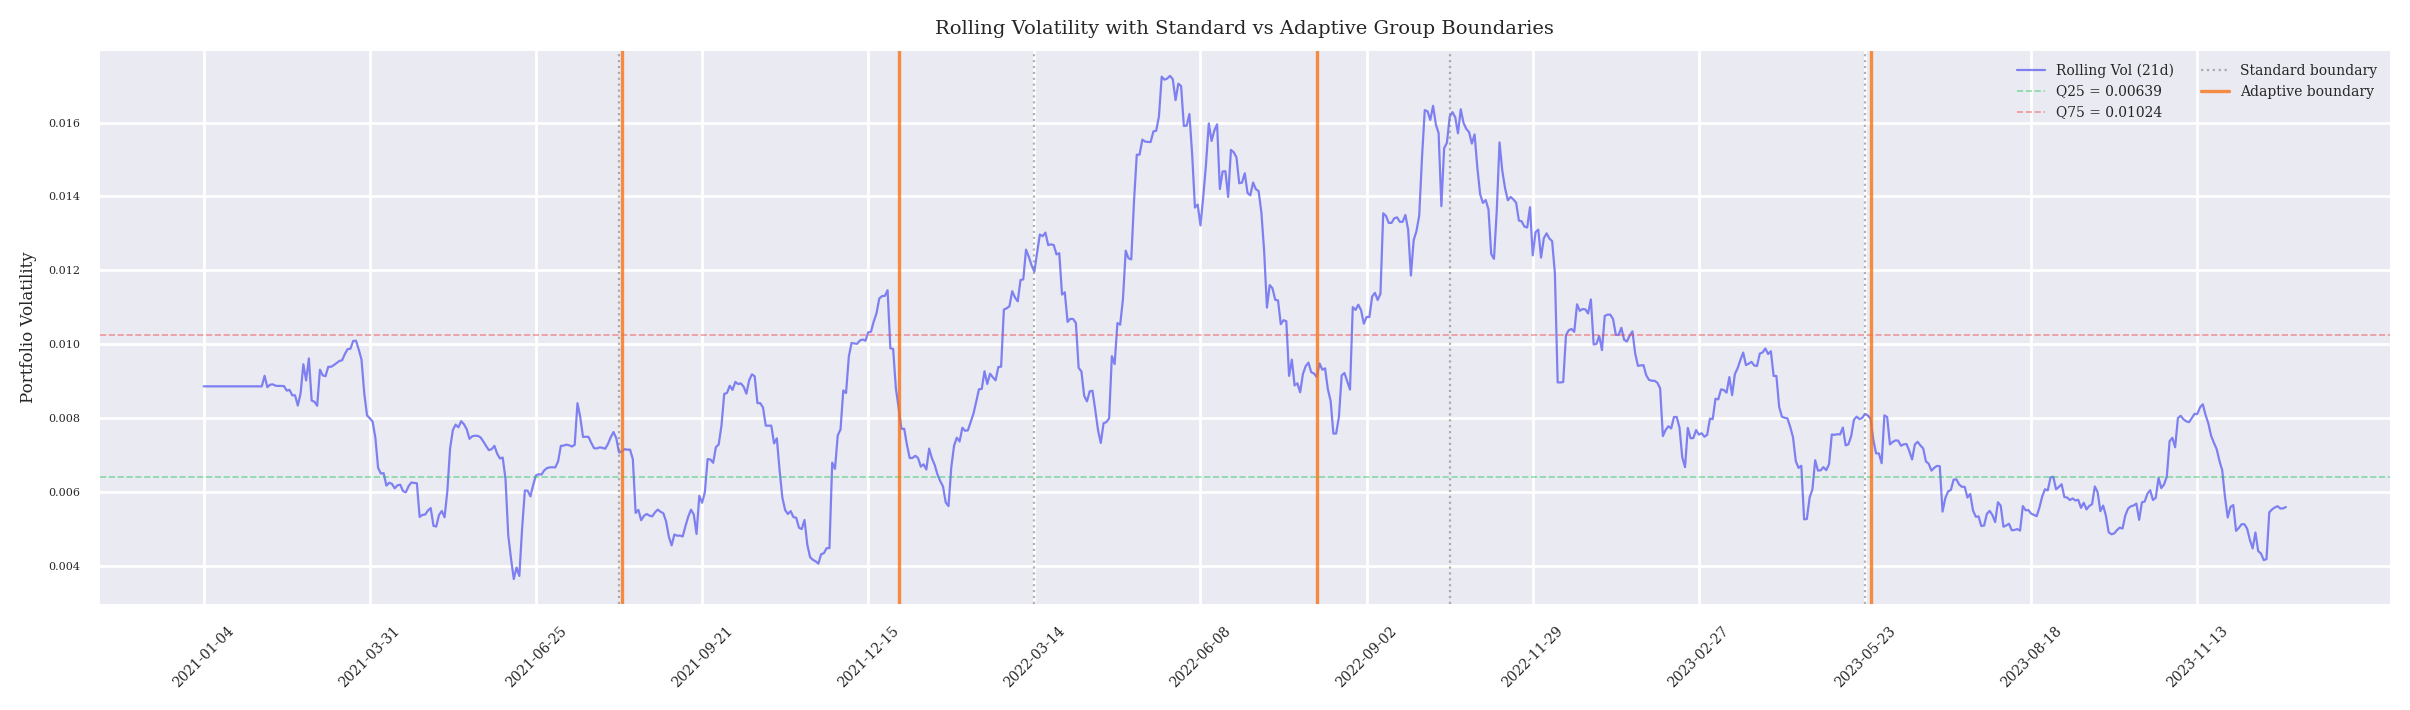

In [20]:
# Plot rolling volatility with standard vs adaptive group boundaries

fig, ax = plt.subplots(figsize=(12, 3.5), dpi=200)

# Volatility curve
ax.plot(dates_ary, vol, color='#6366F1', linewidth=0.8, alpha=0.8, label='Rolling Vol (21d)')

# Quantile thresholds
q_lo = np.quantile(vol, 0.25)
q_hi = np.quantile(vol, 0.75)
ax.axhline(q_lo, color='#22C55E', linestyle='--', linewidth=0.6, alpha=0.5, label=f'Q25 = {q_lo:.5f}')
ax.axhline(q_hi, color='#EF4444', linestyle='--', linewidth=0.6, alpha=0.5, label=f'Q75 = {q_hi:.5f}')

# Standard boundaries (dashed grey)
std_bounds = cv.get_fold_bounds(total_samples)
for g, (s, e) in enumerate(std_bounds):
    if g > 0:
        ax.axvline(dates_ary[s], color='grey', linestyle=':', linewidth=0.8, alpha=0.6,
                   label='Standard boundary' if g == 1 else '')

# Adaptive boundaries (solid orange)
adp_bounds = acv.get_fold_bounds(total_samples)
for g, (s, e) in enumerate(adp_bounds):
    if g > 0:
        ax.axvline(dates_ary[s], color='#F97316', linestyle='-', linewidth=1.2, alpha=0.8,
                   label='Adaptive boundary' if g == 1 else '')

# Format x-axis: show every 60th date
tick_idx = np.arange(0, total_samples, 60)
ax.set_xticks([dates_ary[i] for i in tick_idx])
ax.tick_params(axis='x', rotation=45, labelsize=5)
ax.set_ylabel('Portfolio Volatility', fontsize=6)
ax.set_title('Rolling Volatility with Standard vs Adaptive Group Boundaries', fontsize=7)
ax.legend(fontsize=5, loc='upper right', ncol=2, framealpha=0.8)
plt.tight_layout()

In [21]:
# Boundary comparison table: standard vs adaptive
print(f'{"Group":>6}  {"Standard":>20}  {"Adaptive":>20}  {"Shift":>10}')
print(f'{"─"*6}  {"─"*20}  {"─"*20}  {"─"*10}')
for g, ((ss, se), (as_, ae)) in enumerate(zip(std_bounds, adp_bounds)):
    shift_s = as_ - ss
    shift_e = ae - se
    print(f'{g:>6}  [{ss:>4}:{se:>4}] ({se-ss:>3}d)  '
          f'[{as_:>4}:{ae:>4}] ({ae-as_:>3}d)  '
          f'{shift_s:>+4},{shift_e:>+4}')
    print(f'        {dates_ary[ss]}..{dates_ary[se-1]}'
          f'  {dates_ary[as_]}..{dates_ary[ae-1]}')

 Group              Standard              Adaptive       Shift
──────  ────────────────────  ────────────────────  ──────────
     0  [   0: 150] (150d)  [   0: 151] (151d)    +0,  +1
        2021-01-04..2021-08-06  2021-01-04..2021-08-09
     1  [ 150: 300] (150d)  [ 151: 251] (100d)    +1, -49
        2021-08-09..2022-03-11  2021-08-10..2021-12-30
     2  [ 300: 450] (150d)  [ 251: 402] (151d)   -49, -48
        2022-03-14..2022-10-14  2021-12-31..2022-08-08
     3  [ 450: 600] (150d)  [ 402: 602] (200d)   -48,  +2
        2022-10-17..2023-05-22  2022-08-09..2023-05-24
     4  [ 600: 753] (153d)  [ 602: 753] (151d)    +2,  +0
        2023-05-23..2023-12-29  2023-05-25..2023-12-29


In [22]:
# Inspect adaptive splits
acpcv_splits = list(acv.split(total_samples))

print(f'Adaptive CPCV: {len(acpcv_splits)} splits\n')
for i, (tr, tt) in enumerate(acpcv_splits):
    embargo_idx = sorted(set(range(total_samples)) - set(tr) - set(tt))
    print(f'Split {i+1:2d}: train={len(tr):4d}  test={len(tt):4d}  purge/embargo={len(embargo_idx):3d}')
    print(f'    train: {format_segments(tr)}')
    print(f'    test:  {format_segments(tt)}')

Adaptive CPCV: 10 splits

Split  1: train= 401  test= 351  purge/embargo=  1
    train: [0..400]
    test:  [402..752]
Split  2: train= 442  test= 302  purge/embargo=  9
    train: [0..249] + [409..600]
    test:  [251..401] + [602..752]
Split  3: train= 394  test= 351  purge/embargo=  8
    train: [0..249] + [609..752]
    test:  [251..601]
Split  4: train= 493  test= 251  purge/embargo=  9
    train: [0..149] + [258..600]
    test:  [151..250] + [602..752]
Split  5: train= 437  test= 300  purge/embargo= 16
    train: [0..149] + [258..400] + [609..752]
    test:  [151..250] + [402..601]
Split  6: train= 494  test= 251  purge/embargo=  8
    train: [0..149] + [409..752]
    test:  [151..401]
Split  7: train= 443  test= 302  purge/embargo=  8
    train: [158..600]
    test:  [0..150] + [602..752]
Split  8: train= 387  test= 351  purge/embargo= 15
    train: [158..400] + [609..752]
    test:  [0..150] + [402..601]
Split  9: train= 436  test= 302  purge/embargo= 15
    train: [158..249] +

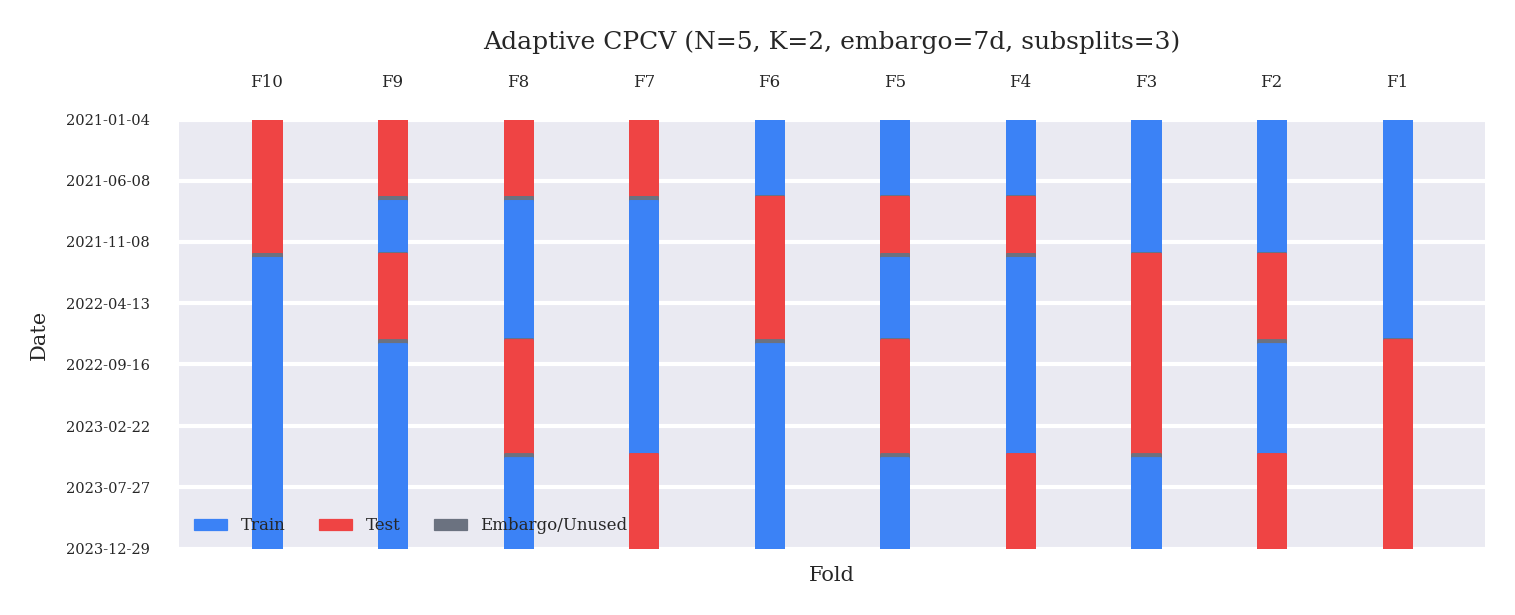

In [23]:
# Plot Adaptive CPCV splits
fig, ax = plt.subplots()
plot_splits_generic(acpcv_splits, total_samples, ax,
                    title=f'Adaptive CPCV (N={N}, K={K}, embargo={embargo}d, subsplits=3)',
                    dates=dates_ary)
plt.gca().invert_yaxis()
plt.tight_layout()

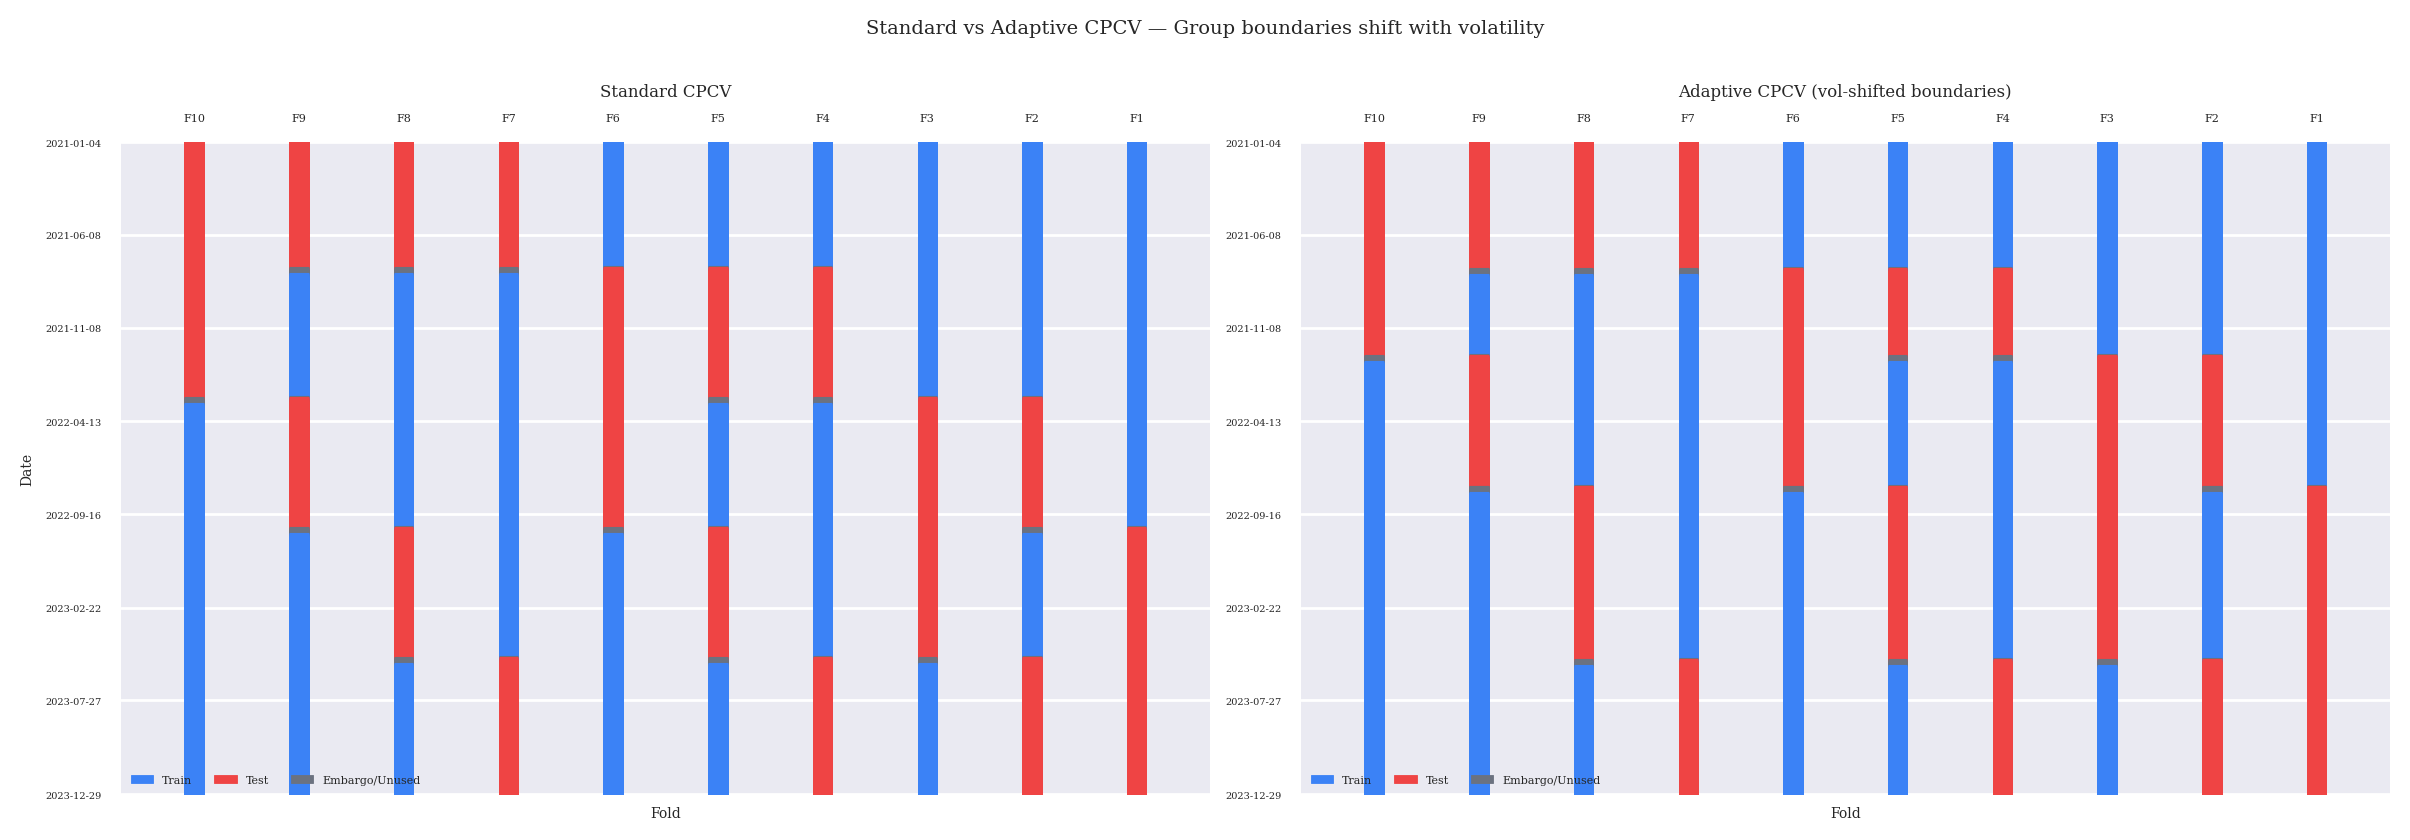

In [24]:
# Side-by-side: Standard CPCV vs Adaptive CPCV
cpcv_splits = list(cv.split(total_samples))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

plot_splits_generic(cpcv_splits, total_samples, axes[0],
                    title=f'Standard CPCV', lw=4, dates=dates_ary)
axes[0].invert_yaxis()

plot_splits_generic(acpcv_splits, total_samples, axes[1],
                    title=f'Adaptive CPCV (vol-shifted boundaries)', lw=4, dates=dates_ary)
axes[1].invert_yaxis()
axes[1].set_ylabel('')

plt.suptitle('Standard vs Adaptive CPCV — Group boundaries shift with volatility',
             fontsize=7, y=1.02)
plt.tight_layout()

In [25]:
# Verify no leakage in adaptive splits
assert verify_no_leakage(acv, total_samples)
print(f'✓ All {acv.n_combinations} adaptive splits are leak-free (embargo={embargo}d)')

✓ All 10 adaptive splits are leak-free (embargo=7d)


### Alternative external features for A-CPCV

The adaptive boundary shifts depend on which market feature we use. Let's compare several options:

1. **Rolling Volatility** (current) — 21-day std of portfolio log returns
2. **VIX** — already in the dataset (CBOE Volatility Index)
3. **Turbulence Index** — already in the dataset (Mahalanobis distance of returns)
4. **Ichimoku Kijun-sen** — 26-day midpoint of portfolio price range (proxy for trend regime)
5. **Rolling Max Drawdown** — 63-day (quarterly) peak-to-trough drawdown
6. **RSI-30** — average RSI(30) across all 28 stocks (overbought/oversold signal)

In [26]:
# Compute alternative external features using the canonical function
import importlib, cpcv_pipeline.function_CPCV as _mod
importlib.reload(_mod)
from cpcv_pipeline.function_CPCV import compute_external_feature, FEATURE_CHOICES

feature_configs = {
    'Rolling Vol (21d)':      ('volatility', 21, False),
    'VIX':                    ('vix',        None, True),
    'Turbulence':             ('turbulence', None, True),
    'Ichimoku (P − Kijun26)': ('ichimoku',   None, False),
    'Drawdown (63d)':         ('drawdown',   63, False),
    'RSI-30 (avg)':           ('rsi',        None, True),
}

features = {}
for label, (fname, window, needs_tech) in feature_configs.items():
    kwargs = dict(close_ary=close_ary, feature_name=fname)
    if window is not None:
        kwargs['window'] = window
    if needs_tech:
        kwargs['tech_ary'] = tech_ary
    features[label] = compute_external_feature(**kwargs)

# Quick stats
print(f'{"Feature":<25} {"Min":>10} {"Max":>10} {"Mean":>10} {"Std":>10}')
print('─' * 68)
for name, f in features.items():
    print(f'{name:<25} {f.min():>10.4f} {f.max():>10.4f} {f.mean():>10.4f} {f.std():>10.4f}')

Feature                          Min        Max       Mean        Std
────────────────────────────────────────────────────────────────────
Rolling Vol (21d)             0.0036     0.0173     0.0087     0.0031
VIX                           5.2500    29.3900    16.4728     5.6763
Turbulence                    0.0000   289.4817    23.9408    31.3579
Ichimoku (P − Kijun26)      -12.0643    12.0168     1.0115     4.4363
Drawdown (63d)               -0.1575     0.0000    -0.0343     0.0355
RSI-30 (avg)                  0.0000    78.0137    51.1609     4.9400


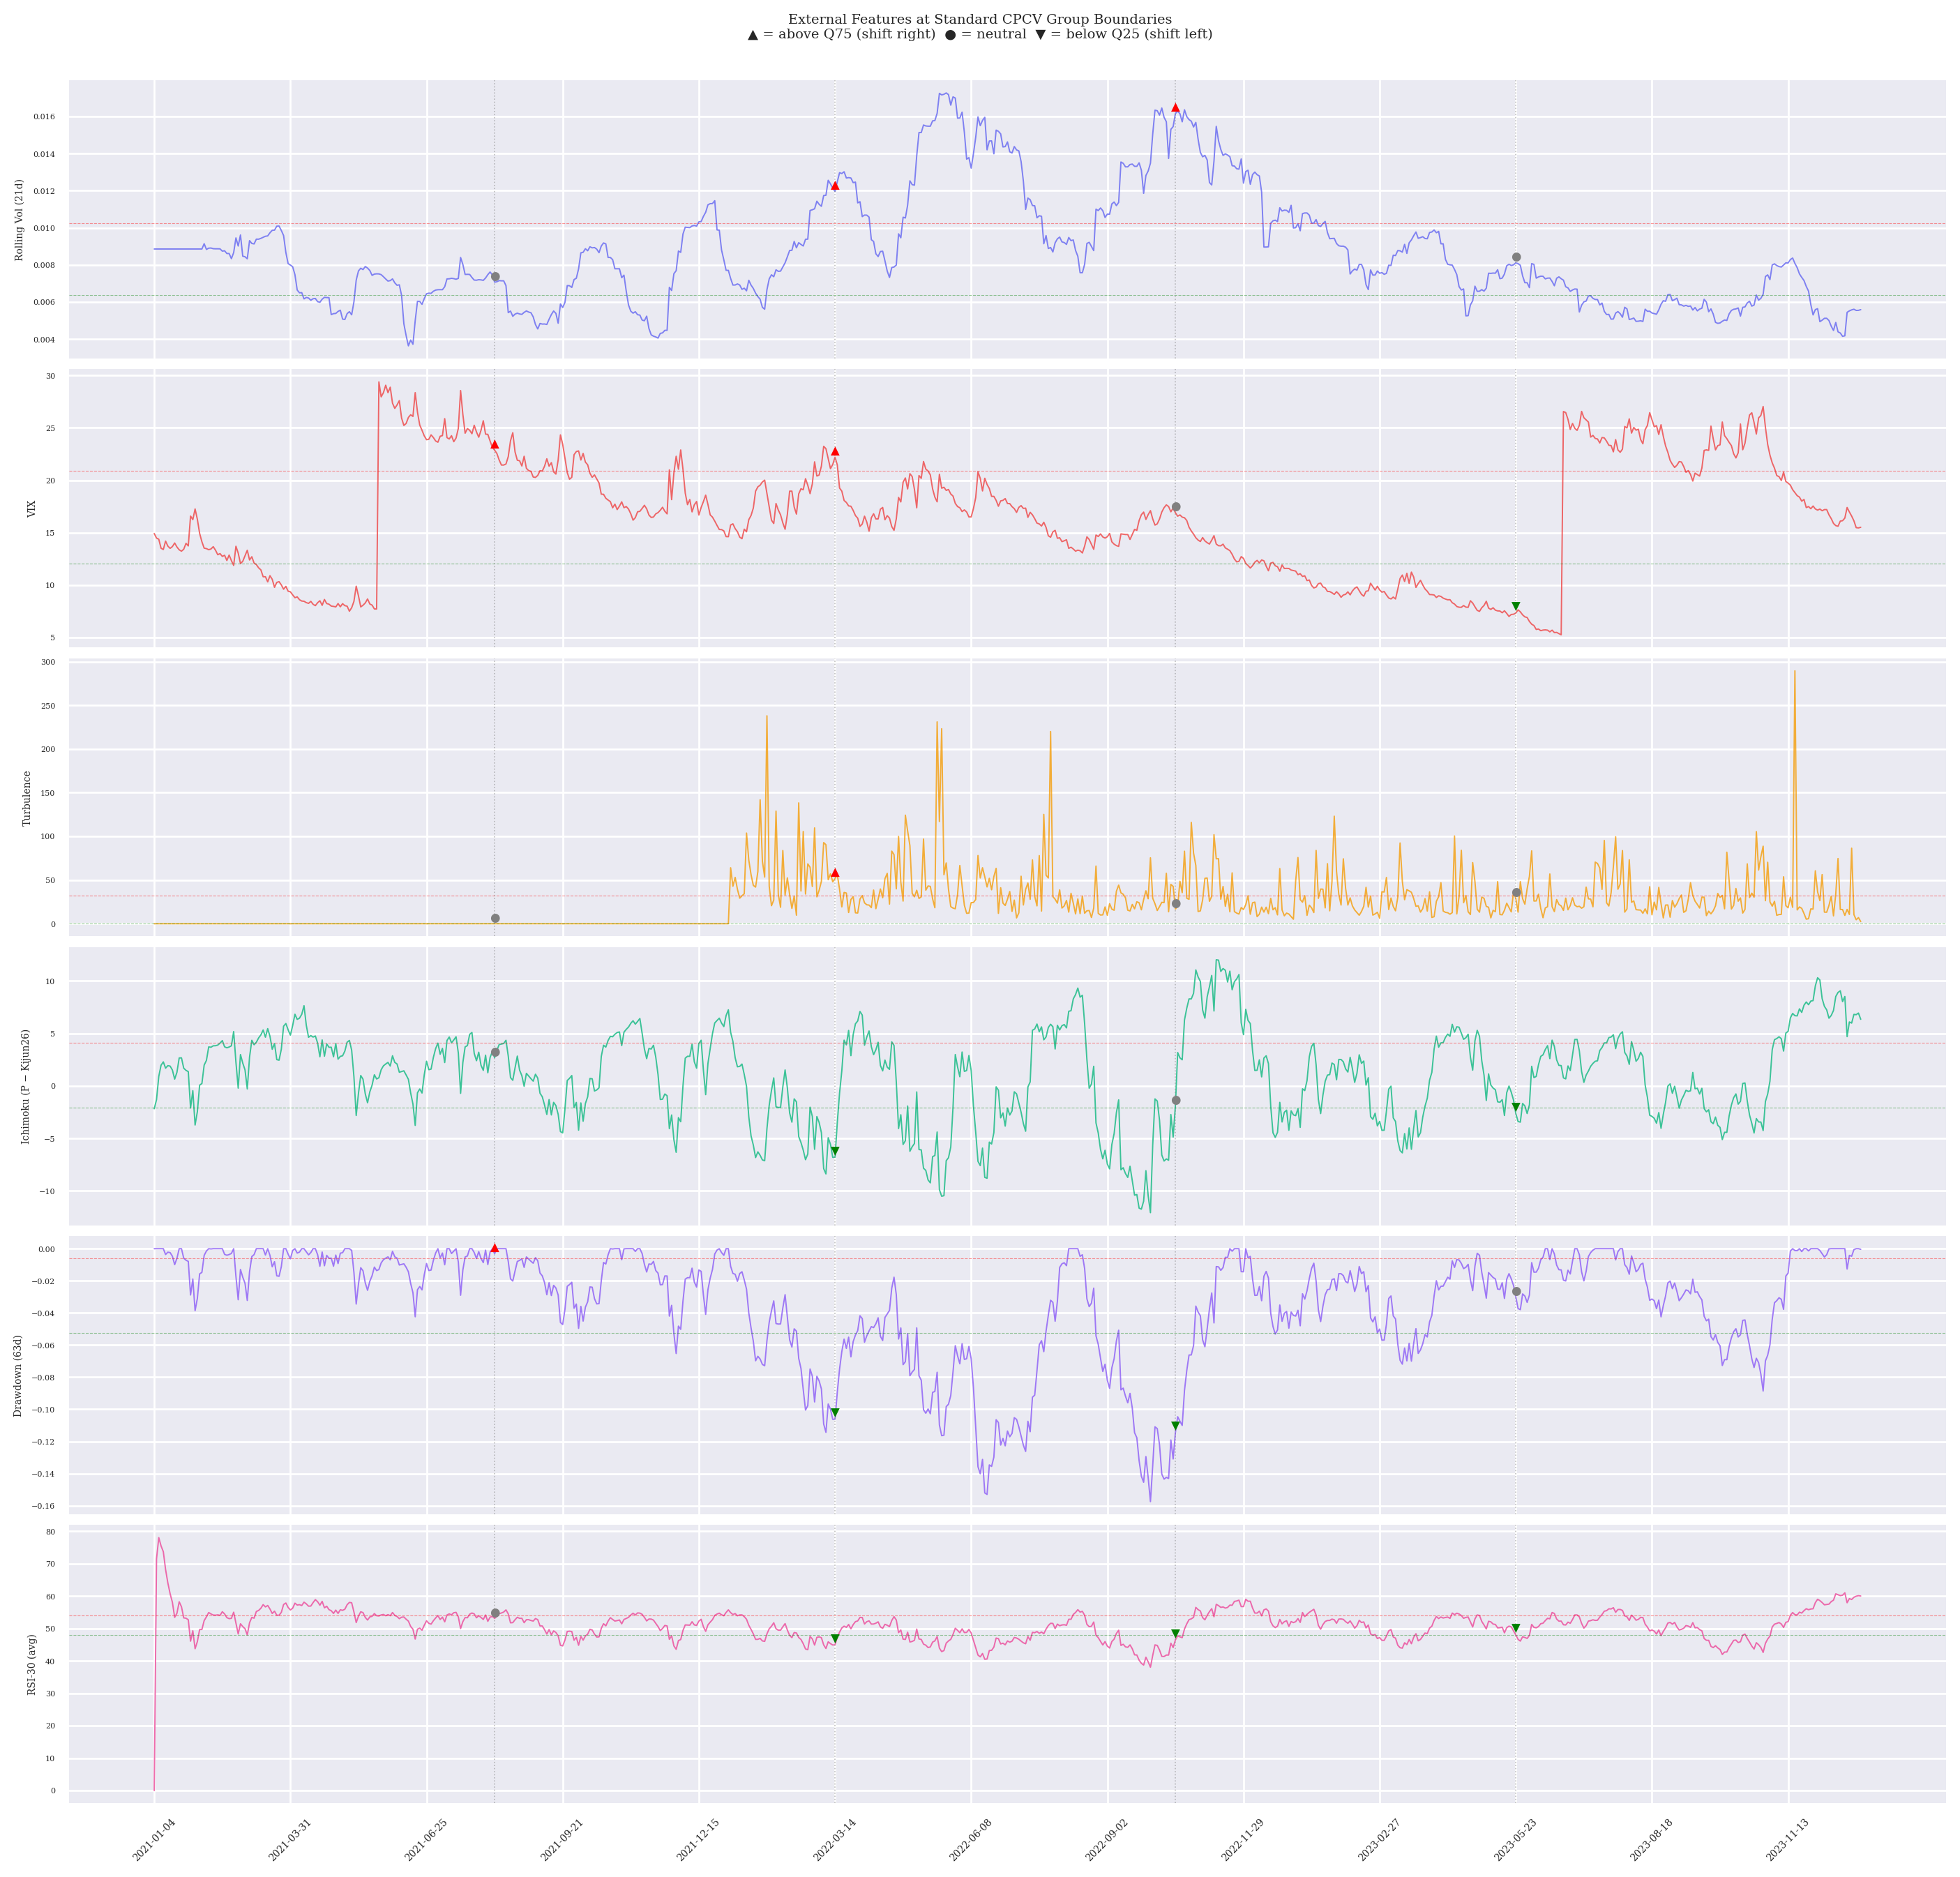

In [27]:
# Plot all features with standard group boundaries
fig, axes = plt.subplots(len(features), 1, figsize=(14, 2.2 * len(features)), dpi=200,
                          sharex=True)

colors = ['#6366F1', '#EF4444', '#F59E0B', '#10B981', '#8B5CF6', '#EC4899']

for ax, (name, feat), color in zip(axes, features.items(), colors):
    ax.plot(dates_ary, feat, color=color, linewidth=0.7, alpha=0.8)
    ax.set_ylabel(name, fontsize=5)

    # Quantile thresholds
    q_lo = np.quantile(feat, 0.25)
    q_hi = np.quantile(feat, 0.75)
    ax.axhline(q_lo, color='green', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.axhline(q_hi, color='red', linestyle='--', linewidth=0.4, alpha=0.4)

    # Standard boundaries
    for g, (s, e) in enumerate(std_bounds):
        if g > 0:
            ax.axvline(dates_ary[s], color='grey', linestyle=':', linewidth=0.6, alpha=0.5)

    # Mark boundary-local feature values
    for g, (s, e) in enumerate(std_bounds):
        if g > 0:
            val = feat[s]
            marker = '▼' if val < q_lo else ('▲' if val > q_hi else '●')
            mcolor = 'green' if val < q_lo else ('red' if val > q_hi else 'grey')
            ax.annotate(marker, xy=(dates_ary[s], val), fontsize=6, color=mcolor,
                       ha='center', va='bottom')

    ax.tick_params(labelsize=4)

# x-axis labels only on bottom
tick_idx = np.arange(0, total_samples, 60)
axes[-1].set_xticks([dates_ary[i] for i in tick_idx])
axes[-1].tick_params(axis='x', rotation=45, labelsize=5)

fig.suptitle('External Features at Standard CPCV Group Boundaries\n'
             '▲ = above Q75 (shift right)  ● = neutral  ▼ = below Q25 (shift left)',
             fontsize=7, y=1.01)
plt.tight_layout()

In [38]:
# Build Adaptive CPCV with each feature and compare boundary shifts

feature_splitters = {}
for name, feat in features.items():
    feature_splitters[name] = AdaptiveCombPurgedKFoldCV(
        n_splits=N, n_test_splits=K, embargo_days=embargo,
        external_feature=feat,
        n_subsplits=3,
        lower_quantile=0.25,
        upper_quantile=0.75,
    )

# Boundary comparison table
print(f'{"Feature":<25}  {"G0":>5}  {"G1":>5}  {"G2":>5}  {"G3":>5}  {"G4":>5}  '
      f'{"Range":>7}  {"MM":>4}  {"AvgGap%":>8}  {"MaxGap%":>8}')
print('─' * 105)

def _count_mismatches(splits):
    """Count regime mismatches using segment-weighted returns (handles non-contiguous indices)."""
    n_mm = 0
    for tr, tt in splits:
        segs_tr = _contiguous_segments(tr)
        segs_tt = _contiguous_segments(tt)
        tr_ret = sum((close_ary[s[-1]].mean() / close_ary[s[0]].mean() - 1) * 100 * len(s)
                     for s in segs_tr) / sum(len(s) for s in segs_tr)
        tt_ret = sum((close_ary[s[-1]].mean() / close_ary[s[0]].mean() - 1) * 100 * len(s)
                     for s in segs_tt) / sum(len(s) for s in segs_tt)
        if (tr_ret < 0 and tt_ret > 15) or (tr_ret > 15 and tt_ret < 0):
            n_mm += 1
    return n_mm

def _regime_gaps(splits):
    """Compute per-split |train_ret - test_ret| gaps."""
    gaps = []
    for tr, tt in splits:
        segs_tr = _contiguous_segments(tr)
        segs_tt = _contiguous_segments(tt)
        tr_ret = sum((close_ary[s[-1]].mean() / close_ary[s[0]].mean() - 1) * 100 * len(s)
                     for s in segs_tr) / sum(len(s) for s in segs_tr)
        tt_ret = sum((close_ary[s[-1]].mean() / close_ary[s[0]].mean() - 1) * 100 * len(s)
                     for s in segs_tt) / sum(len(s) for s in segs_tt)
        gaps.append(abs(tr_ret - tt_ret))
    return gaps

# Standard baseline
sizes = [se - ss for ss, se in std_bounds]
std_splits_for_table = list(cv.split(total_samples))
n_mm_std = _count_mismatches(std_splits_for_table)
gaps_std = _regime_gaps(std_splits_for_table)
print(f'{"Standard CPCV":<25}  {sizes[0]:>5}  {sizes[1]:>5}  {sizes[2]:>5}  '
      f'{sizes[3]:>5}  {sizes[4]:>5}  {max(sizes)-min(sizes):>7}  '
      f'{n_mm_std:>4}  {np.mean(gaps_std):>8.1f}  {max(gaps_std):>8.1f}')

for name, acv_alt in feature_splitters.items():
    bounds = acv_alt.get_fold_bounds(total_samples)
    sizes = [e - s for s, e in bounds]
    splits_alt = list(acv_alt.split(total_samples))
    n_mm = _count_mismatches(splits_alt)
    gaps = _regime_gaps(splits_alt)
    better = '  ✓' if np.mean(gaps) < np.mean(gaps_std) else ''
    
    print(f'{name:<25}  {sizes[0]:>5}  {sizes[1]:>5}  {sizes[2]:>5}  '
          f'{sizes[3]:>5}  {sizes[4]:>5}  {max(sizes)-min(sizes):>7}  '
          f'{n_mm:>4}  {np.mean(gaps):>8.1f}  {max(gaps):>8.1f}{better}')

print(f'\nMM = regime mismatches (train<0% & test>15%, or vice versa)')
print(f'AvgGap = mean |train_return − test_return| across splits (lower = more consistent)')
print(f'MaxGap = worst-case regime difference        (lower = safer)')


Feature                       G0     G1     G2     G3     G4    Range    MM   AvgGap%   MaxGap%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
Standard CPCV                150    150    150    150    153        3     3      12.4      33.2
Rolling Vol (21d)            151    100    151    200    151      100     2      12.7      27.1
VIX                          100    151    201    201    100      101     3      17.6      25.6
Turbulence                   151    100    151    150    201      101     2      13.7      30.5
Ichimoku (P − Kijun26)       151    200    101    201    100      101     2      12.9      28.7
Drawdown (63d)               100    251    151    100    151      151     0       8.9      18.4  ✓
RSI-30 (avg)                 151    200    151    151    100      100     0       9.8      18.9  ✓

MM = regime mismatches (train<0% & test>15%, or vice versa)
AvgGap = mean |train_return − test_return| across splits (l

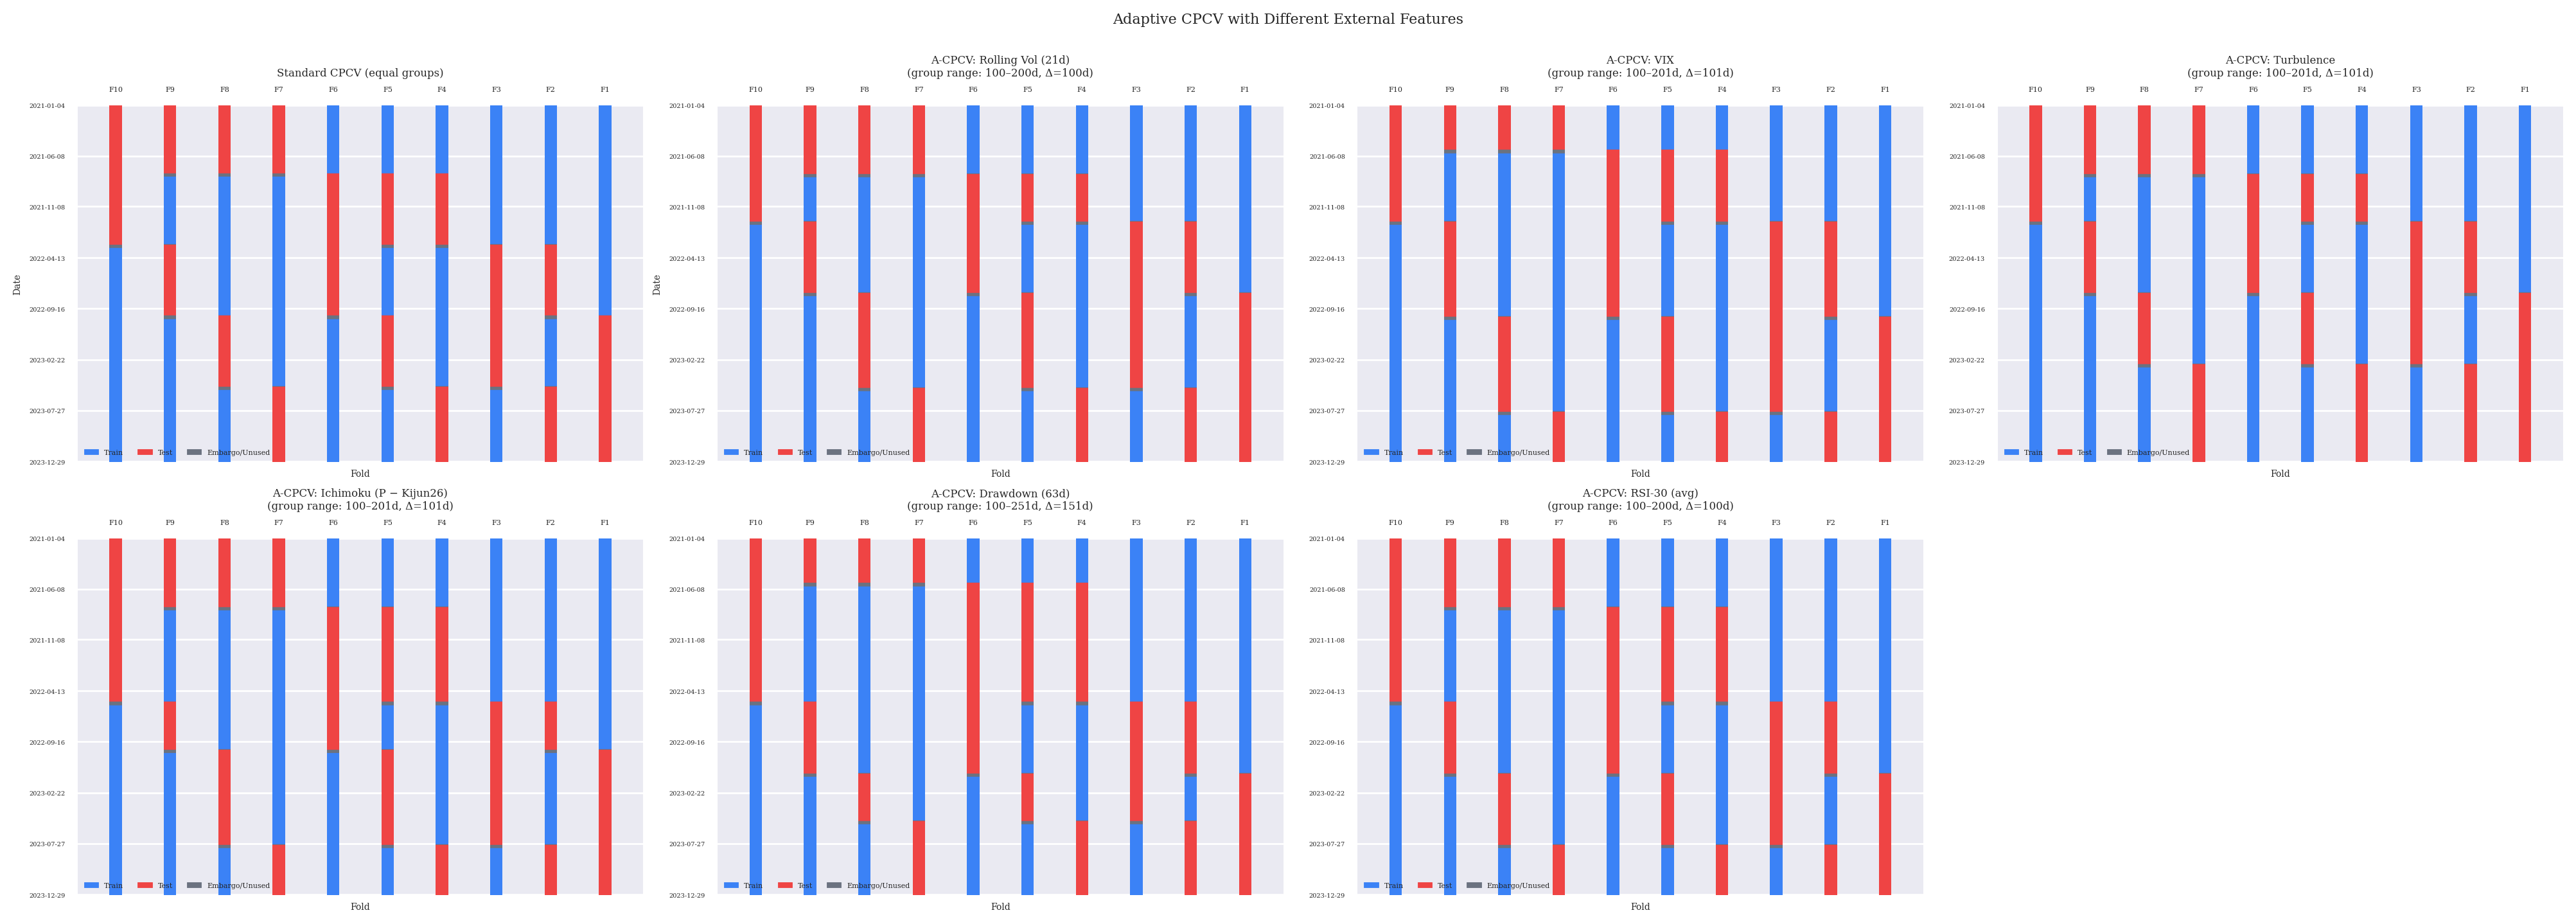

In [29]:
# Side-by-side split plots for each feature
n_plots = 1 + len(feature_splitters)  # standard + each feature
ncols = 4
nrows = (n_plots + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows), dpi=200)
axes = axes.flatten()

# Standard CPCV as reference
plot_splits_generic(cpcv_splits, total_samples, axes[0],
                    title='Standard CPCV (equal groups)', lw=3, dates=dates_ary)
axes[0].invert_yaxis()

for idx, (name, acv_alt) in enumerate(feature_splitters.items()):
    ax = axes[idx + 1]
    splits_alt = list(acv_alt.split(total_samples))
    bounds = acv_alt.get_fold_bounds(total_samples)
    sizes = [e - s for s, e in bounds]
    size_range = max(sizes) - min(sizes)
    plot_splits_generic(splits_alt, total_samples, ax,
                        title=f'A-CPCV: {name}\n(group range: {min(sizes)}–{max(sizes)}d, Δ={size_range}d)',
                        lw=3, dates=dates_ary)
    ax.invert_yaxis()
    if idx > 0:
        ax.set_ylabel('')

# Hide unused subplots
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Adaptive CPCV with Different External Features', fontsize=8, y=1.01)
plt.tight_layout()

In [ ]:
# Detailed regime mismatch comparison — which feature produces the best-aligned splits?
print(f'\n{"Feature":<25}  {"MM":>4}  {"AvgGap%":>8}  {"MaxGap%":>8}  '
      f'{"Min Train":>10}  {"Max Train":>10}  {"Boundary Dates":>50}')
print('─' * 130)

def _boundary_dates(acv_obj):
    bounds = acv_obj.get_fold_bounds(total_samples)
    return ' | '.join(dates_ary[s] for s, e in bounds if s > 0)

# Standard
splits_std = list(cv.split(total_samples))
train_std = [len(tr) for tr, _ in splits_std]
n_mm_std = _count_mismatches(splits_std)
gaps_std = _regime_gaps(splits_std)
std_bdates = ' | '.join(dates_ary[s] for s, e in std_bounds if s > 0)
print(f'{"Standard CPCV":<25}  {n_mm_std:>4}  {np.mean(gaps_std):>8.1f}  {max(gaps_std):>8.1f}  '
      f'{min(train_std):>10}  {max(train_std):>10}  {std_bdates:>50}')

best_name, best_gap = None, 999.0
for name, acv_alt in feature_splitters.items():
    splits_alt = list(acv_alt.split(total_samples))
    train_sizes = [len(tr) for tr, _ in splits_alt]
    n_mm = _count_mismatches(splits_alt)
    gaps = _regime_gaps(splits_alt)
    avg_gap = np.mean(gaps)
    
    if avg_gap < best_gap:
        best_gap, best_name = avg_gap, name
    
    better = '  ✓' if avg_gap < np.mean(gaps_std) else ''
    print(f'{name:<25}  {n_mm:>4}  {avg_gap:>8.1f}  {max(gaps):>8.1f}  '
          f'{min(train_sizes):>10}  {max(train_sizes):>10}  '
          f'{_boundary_dates(acv_alt):>50}{better}')

print(f'\n→ Best feature for regime alignment: {best_name} (AvgGap={best_gap:.1f}%)')
print(f'  (Standard CPCV: AvgGap={np.mean(gaps_std):.1f}%, {n_mm_std} mismatches)')



Feature                    Mismatches   Min Train   Max Train   Train Var                                      Boundary Dates
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Standard CPCV                       3         437         449         3.8   2021-08-09 | 2022-03-14 | 2022-10-17 | 2023-05-23
Rolling Vol (21d)                   2         387         495        39.0   2021-08-10 | 2021-12-31 | 2022-08-09 | 2023-05-25
VIX                                 3         343         545        56.2   2021-05-27 | 2021-12-31 | 2022-10-19 | 2023-08-09
Turbulence                          2         392         495        37.7   2021-08-10 | 2021-12-31 | 2022-08-09 | 2023-03-15
Ichimoku (P − Kijun26)              2         336         543        56.1   2021-08-10 | 2022-05-25 | 2022-10-19 | 2023-08-09
Drawdown (63d)                      0         342         538        67.3   2021-05-27 | 2022-05-25 | 2022-12-30 | 2023-05

---

# Bagged CPCV (B-CPCV)

Same combinatorial split structure as standard CPCV, but **trains multiple agents per split** with different random seeds. At inference time the ensemble of agents is used for prediction.

The splits themselves are **identical** to standard CPCV — only the training loop changes (multiple seeds per split). So the visualization looks the same, but the total number of training runs is `n_splits × n_bags`.

Reference: RiskLabAI — *Bagged Combinatorial Purged Cross-Validation*.

In [31]:
# Bagged CPCV summary
bcv = BaggedCombPurgedKFoldCV(
    n_splits=N, n_test_splits=K, embargo_days=embargo,
    n_bags=5, base_seed=1943,
)

print(f'Bagged CPCV: {bcv.n_combinations} splits × {bcv.n_bags} bags '
      f'= {bcv.n_combinations * bcv.n_bags} total training runs')
print(f'Bag seeds: {bcv.bag_seeds()}')
print(f'Paths: {bcv.n_paths} (same as standard CPCV)')
print()
print(bcv.describe_splits(total_samples))

Bagged CPCV: 10 splits × 5 bags = 50 total training runs
Bag seeds: [1943, 1944, 1945, 1946, 1947]
Paths: 4 (same as standard CPCV)


Bagged CPCV: 5 bags per split (seeds: [1943, 1944, 1945, 1946, 1947])
Total training runs: 10 splits × 5 bags = 50

CPCV Configuration: N=5, K=2, embargo=7d
Total samples: 753
Fold size: 150
Number of splits: 10
Number of paths: 4

Fold boundaries:
  Group 0: [0:150] (150 days)
  Group 1: [150:300] (150 days)
  Group 2: [300:450] (150 days)
  Group 3: [450:600] (150 days)
  Group 4: [600:753] (153 days)

Split details:

  Split 1:
    Test groups: [3, 4]
    Test ranges:  [(450, 753)]  (303 days)
    Train ranges: [(0, 449)]  (449 days)
    ✓ No leakage

  Split 2:
    Test groups: [2, 4]
    Test ranges:  [(300, 450), (600, 753)]  (303 days)
    Train ranges: [(0, 299), (457, 599)]  (441 days)
    ✓ No leakage

  Split 3:
    Test groups: [2, 3]
    Test ranges:  [(300, 600)]  (300 days)
    Train ranges: [(0, 299), (607, 753)]  (445 days)
    ✓ No leak

Note: splits are identical to standard CPCV — bagging trains 5 agents per split with different seeds


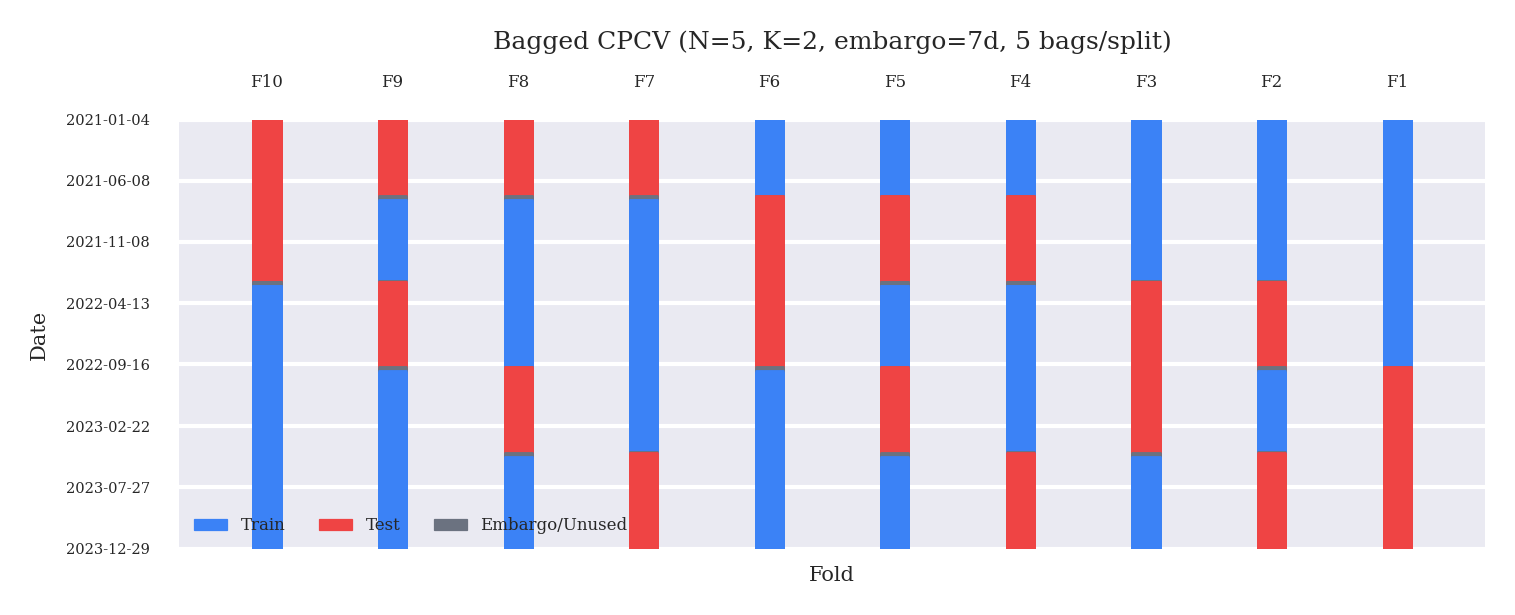

In [32]:
# Plot B-CPCV splits (identical to standard CPCV — visual emphasis on bags)
bcpcv_splits = list(bcv.split(total_samples))

fig, ax = plt.subplots()
plot_splits_generic(bcpcv_splits, total_samples, ax,
                    title=f'Bagged CPCV (N={N}, K={K}, embargo={embargo}d, 5 bags/split)',
                    dates=dates_ary)
plt.gca().invert_yaxis()
plt.tight_layout()
print(f'Note: splits are identical to standard CPCV — '
      f'bagging trains 5 agents per split with different seeds')

---

## Side-by-side comparison: All CV Methods

Standard CPCV, Adaptive CPCV, Bagged CPCV, Walk-Forward, and K-Fold CV — all on the same 753-day Alpaca dataset.

Note: B-CPCV splits are identical to CPCV (only the training differs), so it's omitted from the visual comparison but included in the summary table.

Saved cv_comparison.png


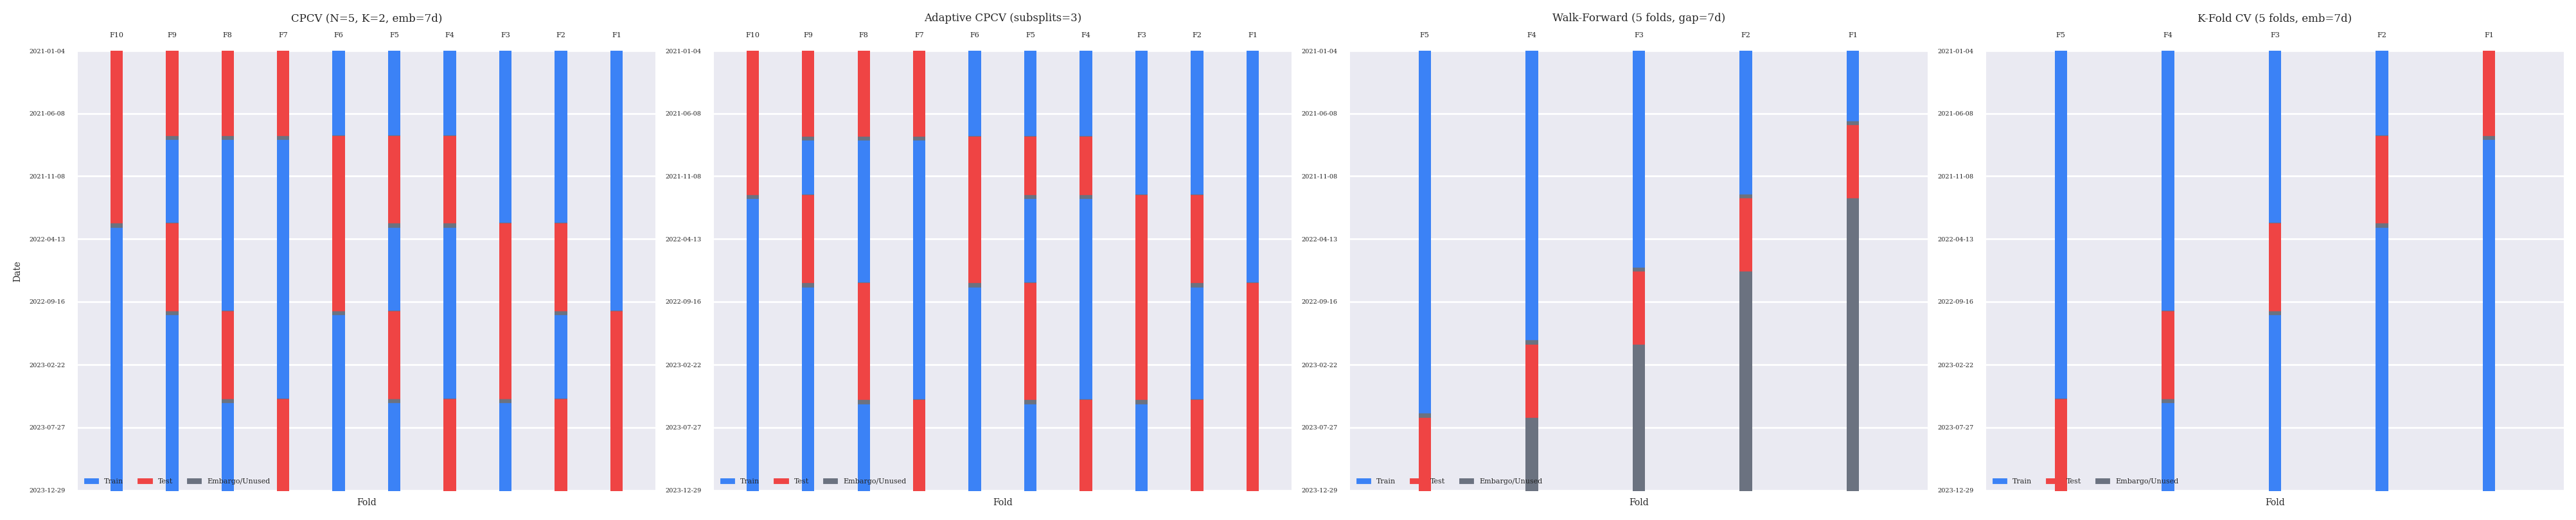

In [33]:
# Side-by-side comparison (4 methods — B-CPCV omitted as visually identical to CPCV)
fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=200)

# CPCV
plot_splits_generic(cpcv_splits, total_samples, axes[0],
                    title=f'CPCV (N={N}, K={K}, emb={embargo}d)', lw=3,
                    dates=dates_ary)
axes[0].invert_yaxis()

# Adaptive CPCV
plot_splits_generic(acpcv_splits, total_samples, axes[1],
                    title=f'Adaptive CPCV (subsplits=3)', lw=3,
                    dates=dates_ary)
axes[1].invert_yaxis()
axes[1].set_ylabel('')

# Walk-Forward
from cpcv_pipeline.config import WF_GAP_DAYS
plot_splits_generic(wf_splits, total_samples, axes[2],
                    title=f'Walk-Forward (5 folds, gap={WF_GAP_DAYS}d)', lw=3,
                    dates=dates_ary)
axes[2].invert_yaxis()
axes[2].set_ylabel('')

# K-Fold CV
plot_splits_generic(kcv_splits, total_samples, axes[3],
                    title=f'K-Fold CV (5 folds, emb={embargo}d)', lw=3,
                    dates=dates_ary)
axes[3].invert_yaxis()
axes[3].set_ylabel('')

plt.tight_layout()
plt.savefig('../cv_comparison.png', dpi=300, bbox_inches='tight')
print('Saved cv_comparison.png')

In [34]:
# Summary table comparing all CV methods
import pandas as pd

def _summarize(name, splits, extra=None):
    train_sizes = [len(tr) for tr, _ in splits]
    test_sizes = [len(tt) for _, tt in splits]
    gap_sizes = [total_samples - len(tr) - len(tt) for tr, tt in splits]
    row = {
        'Method': name,
        'Folds': len(splits),
        'Avg Train': f'{np.mean(train_sizes):.0f}d',
        'Avg Test': f'{np.mean(test_sizes):.0f}d',
        'Avg Gap': f'{np.mean(gap_sizes):.0f}d',
        'Min Train': f'{min(train_sizes)}d',
        'Max Train': f'{max(train_sizes)}d',
        'Future Leakage?': 'No' if name == 'Walk-Forward' else 'Purged',
    }
    if extra:
        row.update(extra)
    return row

summary = pd.DataFrame([
    _summarize('CPCV', cpcv_splits,
               {'Total Runs': len(cpcv_splits), 'Paths': n_paths}),
    _summarize('Adaptive CPCV', acpcv_splits,
               {'Total Runs': len(acpcv_splits), 'Paths': acv.n_paths}),
    _summarize('Bagged CPCV', bcpcv_splits,
               {'Total Runs': f'{len(bcpcv_splits)}×{bcv.n_bags}={len(bcpcv_splits)*bcv.n_bags}',
                'Paths': bcv.n_paths}),
    _summarize('Walk-Forward', wf_splits,
               {'Total Runs': len(wf_splits), 'Paths': 1}),
    _summarize('K-Fold CV', kcv_splits,
               {'Total Runs': len(kcv_splits), 'Paths': 1}),
])
summary.set_index('Method', inplace=True)
summary

,Folds,Avg Train,Avg Test,Avg Gap,Min Train,Max Train,Future Leakage?,Total Runs,Paths
Method,,,,,,,,,
CPCV,10,442d,301d,10d,437d,449d,Purged,10,4
Adaptive CPCV,10,442d,301d,10d,387d,495d,Purged,10,4
Bagged CPCV,10,442d,301d,10d,437d,449d,Purged,10×5=50,4
Walk-Forward,5,375d,124d,254d,125d,625d,No,5,1
K-Fold CV,5,596d,151d,6d,595d,599d,Purged,5,1


## Market regime per split

Buy-hold return for each split's train/test period. When train and test come from different market regimes (bull vs bear), expect negative alpha — the agent learned the wrong regime.


In [35]:
# Market regime analysis — buy-hold return per split
# dates_ary already loaded in the data loading cell above

def _bh_return(idx):
    """Equal-weight buy-hold return over index range."""
    return (close_ary[idx[-1]].mean() / close_ary[idx[0]].mean() - 1) * 100

def _bh_return_segments(idx):
    """Buy-hold return computed per contiguous segment, then averaged."""
    segs = _contiguous_segments(idx)
    if len(segs) == 1:
        return _bh_return(idx)
    # Weighted average by segment length
    total_len = sum(len(s) for s in segs)
    return sum(_bh_return(s) * len(s) / total_len for s in segs)

def _period_str(idx):
    """Show contiguous segments separated by ' + '."""
    segs = _contiguous_segments(idx)
    return ' + '.join(f'{dates_ary[s[0]]}..{dates_ary[s[-1]]}' for s in segs)

def _regime_table(method_name, splits):
    rows = []
    for i, (tr, tt) in enumerate(splits):
        tr_ret = _bh_return_segments(tr)
        tt_ret = _bh_return_segments(tt)
        mismatch = '⚠' if (tr_ret < 0 and tt_ret > 15) or (tr_ret > 15 and tt_ret < 0) else ''
        row = {
            'Fold': i + 1,
            'Train Period': _period_str(tr),
            'Train Days': len(tr),
            'Train Return': f'{tr_ret:+.1f}%',
            'Test Period': _period_str(tt),
            'Test Days': len(tt),
            'Test Return': f'{tt_ret:+.1f}%',
            'Mismatch': mismatch,
        }
        rows.append(row)
    return pd.DataFrame(rows).set_index('Fold')

print('=== CPCV ===')
display(_regime_table('CPCV', cpcv_splits))

print('\n=== Adaptive CPCV ===')
display(_regime_table('Adaptive CPCV', acpcv_splits))

print('\n=== Walk-Forward ===')
display(_regime_table('Walk-Forward', wf_splits))

print('\n=== K-Fold CV ===')
display(_regime_table('K-Fold CV', kcv_splits))

=== CPCV ===


,Train Period,Train Days,Train Return,Test Period,Test Days,Test Return,Mismatch
Fold,,,,,,,
1,2021-01-04..2022-10-13,449,-0.4%,2022-10-17..2023-12-29,303,+25.2%,⚠
2,2021-01-04..2022-03-10 + 2022-10-26..2023-05-19,441,+8.1%,2022-03-14..2022-10-14 + 2023-05-23..2023-12-29,303,+2.4%,
3,2021-01-04..2022-03-10 + 2023-06-02..2023-12-29,445,+10.3%,2022-03-14..2023-05-22,300,+1.6%,
4,2021-01-04..2021-08-05 + 2022-03-23..2023-05-19,441,+3.9%,2021-08-09..2022-03-11 + 2023-05-23..2023-12-29,303,+4.1%,
5,2021-01-04..2021-08-05 + 2022-03-23..2022-10-1...,437,+5.4%,2021-08-09..2022-03-11 + 2022-10-17..2023-05-22,300,+2.0%,
6,2021-01-04..2021-08-05 + 2022-10-26..2023-12-29,445,+17.8%,2021-08-09..2022-10-14,300,-15.4%,⚠
7,2021-08-18..2023-05-19,442,-4.1%,2021-01-04..2021-08-06 + 2023-05-23..2023-12-29,303,+15.4%,⚠
8,2021-08-18..2022-10-13 + 2023-06-02..2023-12-29,438,-5.3%,2021-01-04..2021-08-06 + 2022-10-17..2023-05-22,300,+13.4%,
9,2021-08-18..2022-03-10 + 2022-10-26..2023-12-29,438,+11.0%,2021-01-04..2021-08-06 + 2022-03-14..2022-10-14,300,+3.4%,



=== Adaptive CPCV ===


,Train Period,Train Days,Train Return,Test Period,Test Days,Test Return,Mismatch
Fold,,,,,,,
1,2021-01-04..2022-08-05,401,+8.6%,2022-08-09..2023-12-29,351,+15.5%,
2,2021-01-04..2021-12-29 + 2022-08-18..2023-05-23,442,+10.5%,2021-12-31..2022-08-08 + 2023-05-25..2023-12-29,302,+2.9%,
3,2021-01-04..2021-12-29 + 2023-06-06..2023-12-29,394,+17.7%,2021-12-31..2023-05-24,351,-9.4%,⚠
4,2021-01-04..2021-08-06 + 2022-01-11..2023-05-23,493,-0.9%,2021-08-10..2021-12-30 + 2023-05-25..2023-12-29,251,+10.5%,
5,2021-01-04..2021-08-06 + 2022-01-11..2022-08-0...,437,+6.7%,2021-08-10..2021-12-30 + 2022-08-09..2023-05-24,300,+1.3%,
6,2021-01-04..2021-08-06 + 2022-08-18..2023-12-29,494,+12.9%,2021-08-10..2022-08-08,251,-6.8%,
7,2021-08-19..2023-05-23,443,-5.0%,2021-01-04..2021-08-09 + 2023-05-25..2023-12-29,302,+15.7%,⚠
8,2021-08-19..2022-08-05 + 2023-06-06..2023-12-29,387,+1.0%,2021-01-04..2021-08-09 + 2022-08-09..2023-05-24,351,+7.1%,
9,2021-08-19..2021-12-29 + 2022-08-18..2023-12-29,436,+9.9%,2021-01-04..2021-08-09 + 2021-12-31..2022-08-08,302,+3.3%,



=== Walk-Forward ===


,Train Period,Train Days,Train Return,Test Period,Test Days,Test Return,Mismatch
Fold,,,,,,,
1,2021-01-04..2021-07-01,125,+14.4%,2021-07-14..2022-01-07,125,+3.6%,
2,2021-01-04..2021-12-29,250,+20.6%,2022-01-10..2022-07-11,125,-13.4%,⚠
3,2021-01-04..2022-06-29,375,+2.6%,2022-07-12..2023-01-06,125,+8.6%,
4,2021-01-04..2022-12-27,500,+10.1%,2023-01-09..2023-07-10,125,+1.5%,
5,2021-01-04..2023-06-28,625,+12.4%,2023-07-11..2023-12-29,121,+10.2%,



=== K-Fold CV ===


,Train Period,Train Days,Train Return,Test Period,Test Days,Test Return,Mismatch
Fold,,,,,,,
1,2021-08-18..2023-12-29,596,+8.4%,2021-01-04..2021-08-06,150,+16.5%,
2,2021-01-04..2021-08-05 + 2022-03-23..2023-12-29,595,+11.9%,2021-08-09..2022-03-11,150,-6.4%,
3,2021-01-04..2022-03-10 + 2022-10-26..2023-12-29,595,+14.1%,2022-03-14..2022-10-14,150,-9.7%,
4,2021-01-04..2022-10-13 + 2023-06-02..2023-12-29,595,+2.6%,2022-10-17..2023-05-22,150,+10.3%,
5,2021-01-04..2023-05-19,599,+10.9%,2023-05-23..2023-12-29,153,+14.3%,
